# week5 solutions
### Peilin Luo

In [288]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from riskill import risk
import statsmodels.api as sm
import datetime

### problem 1

In [289]:
underlying = 165
rf = 0.0425
divRate = 0.0053
current = datetime.datetime(2023, 3, 3)
expire = datetime.datetime(2023, 3, 17)
calendarDays = (datetime.datetime(2023, 12, 31) - datetime.datetime(2022, 12, 31)).days
ttm = (expire - current).days / calendarDays
print("time to maturity: ", round(ttm, 6))
b = rf - divRate

time to maturity:  0.038356


In [290]:
def gbsm(call:bool, underlying, strike, ttm, rf, b, ivol):
    d1 = (np.log(underlying/strike) + (b + ivol**2 / 2) * ttm) / (ivol * np.sqrt(ttm))
    d2 = d1 - ivol * np.sqrt(ttm)
    if call:
        return underlying*np.exp((b-rf)*ttm)*sps.norm.cdf(d1) - strike*np.exp(-rf*ttm)*sps.norm.cdf(d2)
    elif not call:
        return strike*np.exp(-rf*ttm)*sps.norm.cdf(-d2) - underlying*np.exp((b-rf)*ttm)*sps.norm.cdf(-d1)
    else:
        raise ValueError("call must be True or False")

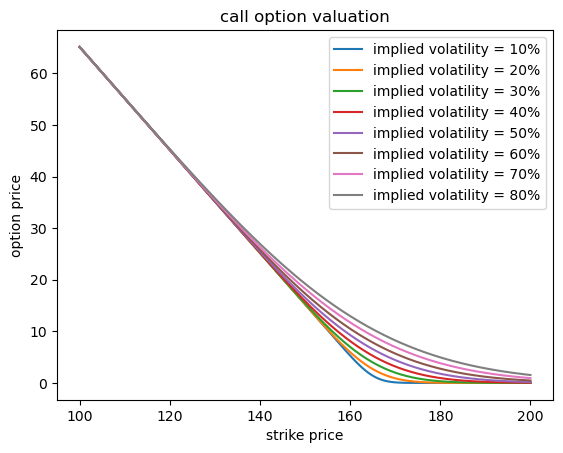

In [291]:
for i in range(1, 9, 1):
    ivol = i/10
    strike = np.linspace(100, 200, 1000)
    calls = gbsm(True, underlying, strike, ttm, rf, b, ivol)
    plt.plot(strike, calls, label='implied volatility = {:.0f}%'.format(ivol*100))
plt.title("call option valuation")
plt.xlabel("strike price")
plt.ylabel("option price")
plt.legend()
plt.show()

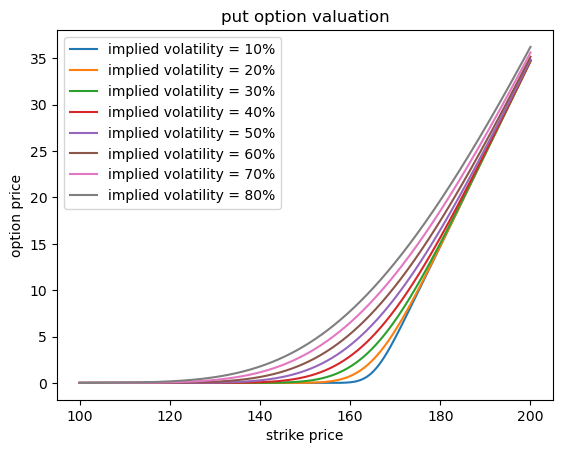

In [292]:
for i in range(1, 9, 1):
    ivol = i/10
    strike = np.linspace(100, 200, 1000)
    puts = gbsm(False, underlying, strike, ttm, rf, b, ivol)
    plt.plot(strike, puts, label='implied volatility = {:.0f}%'.format(ivol*100))
plt.title("put option valuation")
plt.xlabel("strike price")
plt.ylabel("option price")
plt.legend()
plt.show()

### problem 2

In [293]:
options_df = pd.read_csv("AAPL_Options.csv")
options_df['Expiration'] = pd.to_datetime(options_df['Expiration'])
underlying = 151.03
ivols = {'Call': [], 'Put': []}

In [294]:
def find_iv(call:bool, underlying, strike, ttm, rf, b, option_price, guess):
    def equation(iv, call, underlying, strike, ttm, rf, b, option_price):
        return gbsm(call, underlying, strike, ttm, rf, b, iv) - option_price
    sol = fsolve(equation, guess, args=(call, underlying, strike, ttm, rf, b, option_price))
    return float(sol)

In [295]:
for i in range(options_df.shape[0]):
    ttm = (options_df['Expiration'][i] - current).days / calendarDays
    strike = options_df['Strike'][i]
    option_price = options_df['Last Price'][i]
    if options_df['Type'][i] == 'Call':
        call = True
    elif options_df['Type'][i] == 'Put':
        call = False
    else:
        raise ValueError("Type must be Call or Put")
    ivols[options_df['Type'][i]].append(find_iv(call, underlying, strike, ttm, rf, b, option_price, 0.3))

In [306]:
ivols

{'Call': [0.37459682115995235,
  0.3423511538171369,
  0.2925216590839885,
  0.29935752028134016,
  0.27874294420461054,
  0.2631405289480975,
  0.2468277371698956,
  0.23524196254694704,
  0.2235674181751845,
  0.21933931261562725,
  0.21834182282427841],
 'Put': [0.33461470145340916,
  0.31447293427037987,
  0.2977719305313232,
  0.2809944301488997,
  0.2675315704022568,
  0.255133750545917,
  0.24241662733268826,
  0.24569965543006636,
  0.27349317064342576,
  0.295413741427594,
  0.3612428016928175]}

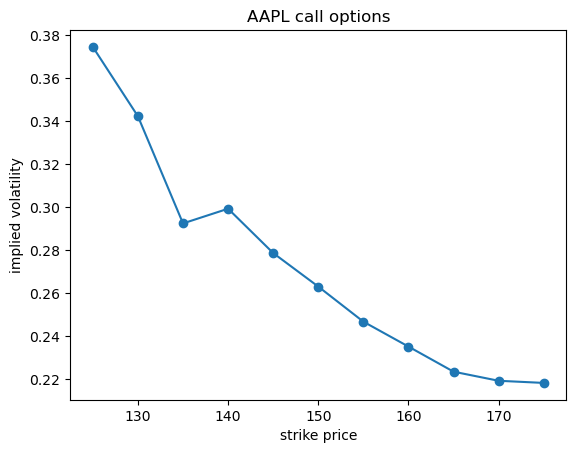

In [296]:
plt.plot(options_df[options_df['Type'] == 'Call']['Strike'], ivols['Call'], '-o')
plt.xlabel('strike price')
plt.ylabel('implied volatility')
plt.title('AAPL call options');

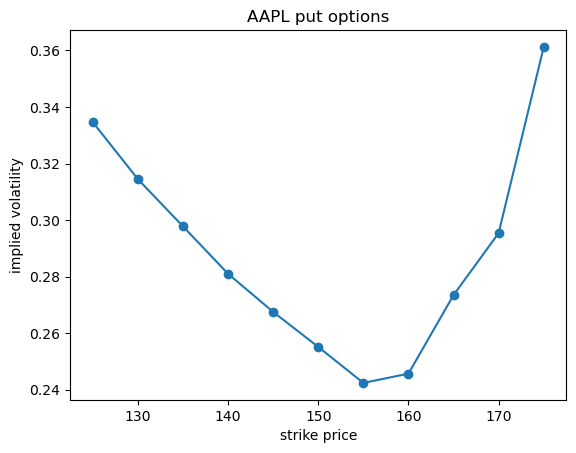

In [297]:
plt.plot(options_df[options_df['Type'] == 'Put']['Strike'], ivols['Put'], '-o')
plt.xlabel('strike price')
plt.ylabel('implied volatility')
plt.title('AAPL put options');

### problem 3

In [298]:
portfolio_df = pd.read_csv('problem3.csv')
portfolio_df['ExpirationDate'] = pd.to_datetime(portfolio_df['ExpirationDate'])

In [299]:
prices_df = pd.read_csv("DailyPrices.csv")
prices_df['Date'] = pd.to_datetime(prices_df['Date'])

In [300]:
underlying = 151.03
key = portfolio_df['Portfolio'].unique()
portfolios = {}
for i in range(key.size):
    portfolios[key[i]] = portfolio_df[portfolio_df['Portfolio'] == key[i]]

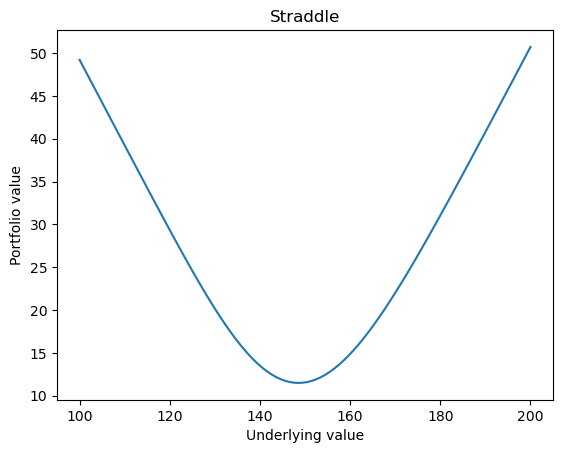

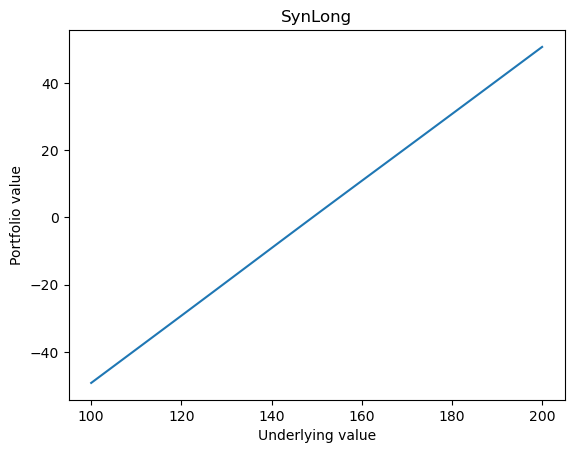

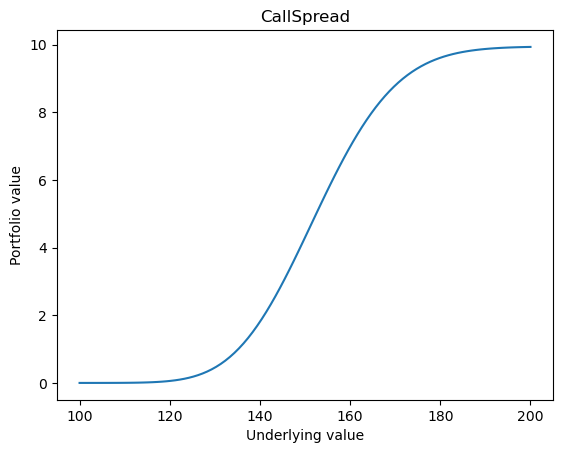

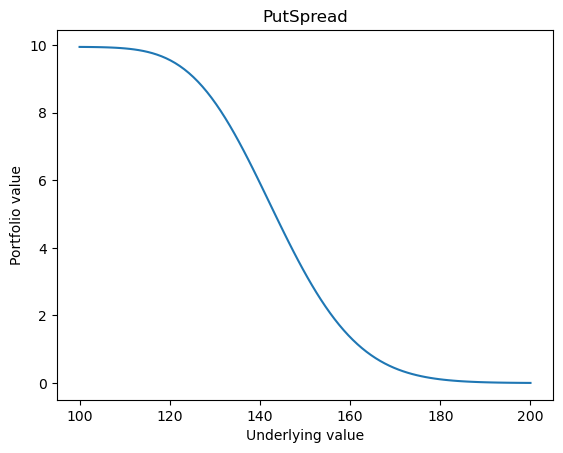

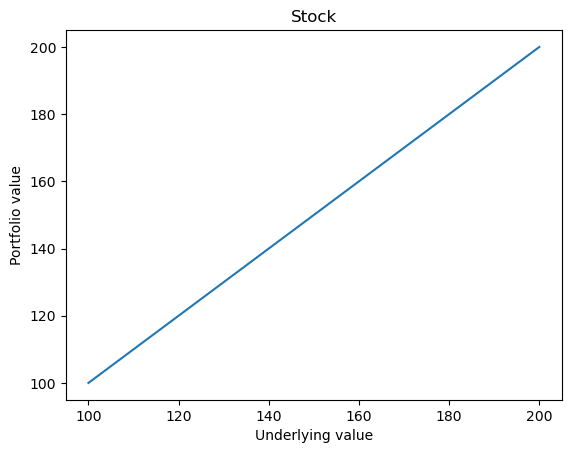

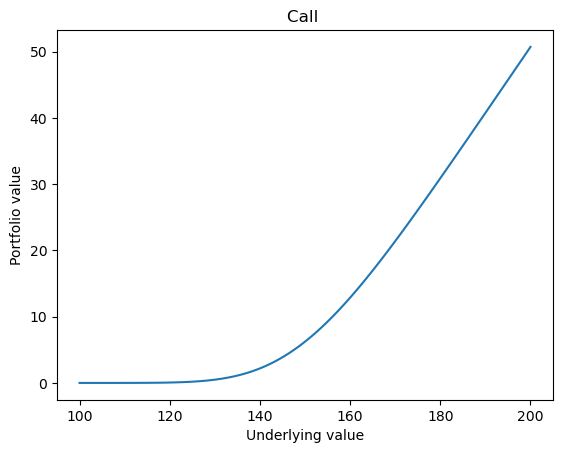

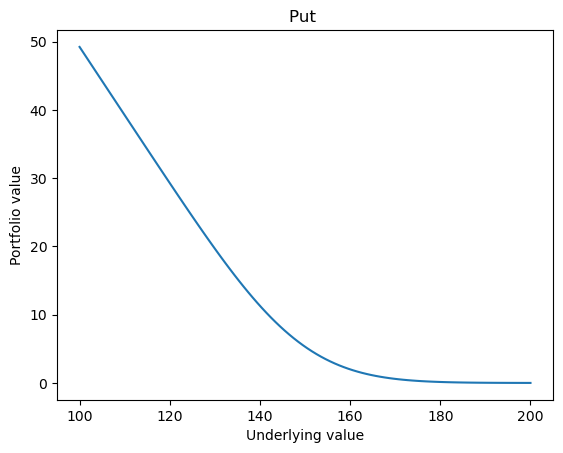

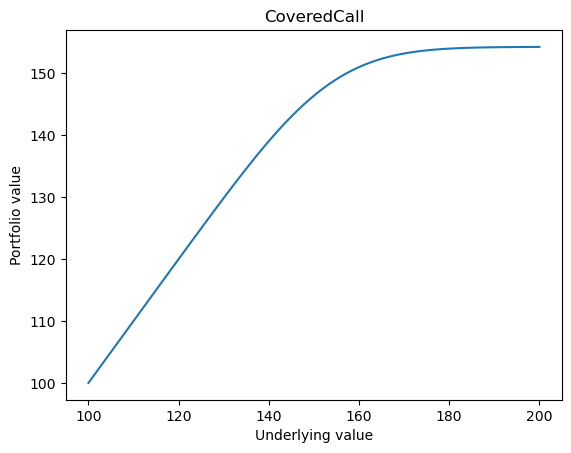

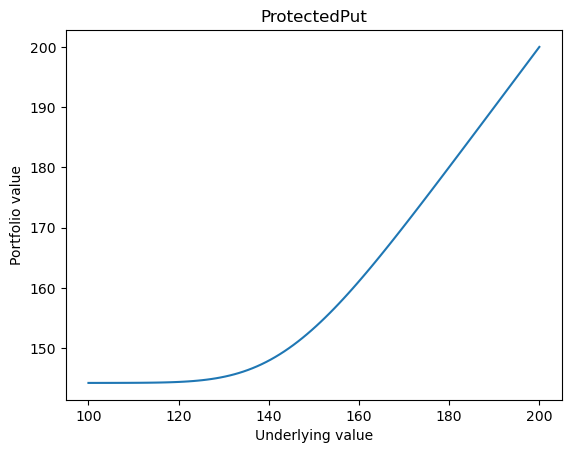

In [301]:
for k, v in portfolios.items():
    v.reset_index(inplace=True)
    total_values = np.zeros(100)
    for i in range(v.shape[0]):
        if v['Type'][i] == 'Option':
            if v['OptionType'][i] == 'Call':
                call = True
            elif v['OptionType'][i] == 'Put':
                call = False
            else:
                raise ValueError("OptionType must be Call or Put")

            ttm = (v['ExpirationDate'][i] - current).days / calendarDays
            iv = find_iv(call, underlying, v['Strike'][i], ttm, rf, b, v['CurrentPrice'][i], 0.3)
            underlyings = np.linspace(100, 200, 100)
            prices = gbsm(call, underlyings, v['Strike'][i], ttm, rf, b, iv)
        elif v['Type'][i] == 'Stock':
            prices = np.linspace(100, 200, 100)
        else:
            raise ValueError("Type must be Option or Stock")

        values = prices * v['Holding'][i]
        total_values += values

    plt.plot(np.linspace(100, 200, 100), total_values)
    plt.title(k)
    plt.xlabel('Underlying value')
    plt.ylabel('Portfolio value')
    plt.show()

In [302]:
ap_returns = risk.return_calculate(prices_df, 'log')['AAPL']
ap_returns -= ap_returns.mean()

In [303]:
# simulate AAPL returns 10 days ahead with AR(1) model
result = sm.tsa.AutoReg(ap_returns, lags=1).fit()
m = result.params[0]
beta = result.params[1]
er_scale = result.sigma2**(1/2)

sim_times = 10_000
ret_t_1 = np.ones(sim_times) * ap_returns[-1]
sim_10_ret = np.zeros((sim_times, 1))
for i in range(10):
    sim_ret_t = beta * ret_t_1 + np.random.normal(0, er_scale, sim_times) + m
    ret_t_1 = sim_ret_t
    sim_10_ret = np.concatenate((sim_10_ret, sim_ret_t.reshape(-1, 1)), axis=1)

sim_10_ret = np.delete(sim_10_ret, 0, 1)

C:\Users\peili\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [304]:
new_prices = underlying
for i in range(10):
    new_prices *= np.exp(sim_10_ret[:, i])

In [305]:
for k, v in portfolios.items():
    current_value = v['Holding']@v['CurrentPrice']
    total_values = np.zeros(sim_times)
    for i in range(v.shape[0]):
        if v['Type'][i] == 'Option':
            if v['OptionType'][i] == 'Call':
                call = True
            elif v['OptionType'][i] == 'Put':
                call = False
            else:
                raise ValueError("OptionType must be Call or Put")

            ttm = (v['ExpirationDate'][i] - current).days / calendarDays
            iv = find_iv(call, underlying, v['Strike'][i], ttm, rf, b, v['CurrentPrice'][i], 0.3)
            ttm2 = ((v['ExpirationDate'][i] - current).days - 10) / calendarDays
            prices = gbsm(call, new_prices, v['Strike'][i], ttm2, rf, b, iv)
        elif v['Type'][i] == 'Stock':
            prices = new_prices
        else:
            raise ValueError("Type must be Option or Stock")

        values = prices * v['Holding'][i]
        total_values += values

    VaR, ES = risk.VaR_ES(total_values - current_value)
    print("For portfolio", k)
    print("PL mean:", round((total_values - current_value).mean(), 6))
    print("VaR and ES:", round(VaR, 6), round(ES, 6))

For portfolio Straddle
PL mean: 1.539893
VaR and ES: 1.379747 1.387658
For portfolio SynLong
PL mean: -0.029165
VaR and ES: 16.195694 20.031152
For portfolio CallSpread
PL mean: -0.102893
VaR and ES: 3.885228 4.187273
For portfolio PutSpread
PL mean: 0.305976
VaR and ES: 2.62823 2.801739
For portfolio Stock
PL mean: 0.174203
VaR and ES: 15.953565 19.76611
For portfolio Call 
PL mean: 0.755364
VaR and ES: 6.031881 6.368979
For portfolio Put 
PL mean: 0.784529
VaR and ES: 4.364466 4.58912
For portfolio CoveredCall
PL mean: -0.713911
VaR and ES: 12.140303 15.833802
For portfolio ProtectedPut
PL mean: 0.833799
VaR and ES: 8.061811 8.694322
